# STDP Generates Error Correcting Code 
## Abstract
It is known that in the literature that when combined with appropriate architecture, data preprocessing and training schedule, Spike-Timing Dependent Plasticity (STDP) can be used as a mean of unsupervised learning. For instance, in Diehl and Cook (2015), a three-layer spiking neural network achieves 95% accuracy on MNIST dataset in which the training is completely *unsupervised*. However, those kind of results most likely takes advantages of synergetic interactions between many factors and therefore often the precise roles of STDP is not entirely clear. In this notebook, we study a network of a toy spiking neuron model, namely, inetegrate-and-fire model with STDP and demostrate STDP *alone* reduces the output entropy i.e. it leads to an error correcting code. 

## Introduction
For certain, real biological neurons are complicated and very likely there are still unknown aspects even at a single neuron level, not to mention the network of them. For a single neuron alone, the golden standard of all models, Hodgekin-Huxley model, with the most concrete biophysical meaning, has 4 coupled non-linear ODEs. One can imagine the diffuculty to analyze of a network of them increases quickly with the size of the network. Instead of building the most biologically accurate model (which we are trying to do as well, separtely), here we study an extremely simplified neuron model and the effect of STDP. It is of the author's interests that this toy model could be studied analytically while still highlights the essential idea. Soon we hope to depart from this simple model and brigde the two ends of the spectrum of means of investigation.

###  Integrate-and-Fire (IF) Model
In the model, neuron are modeled as some kind of intergator. Each neuron has a counter, which roughly correpsonds to the membrane potential. Within a network, neurons synapse onto each other. Every time a pre-synaptic neuron spikes, the pos-synaptic neuron's couter (membrane potential)  would increase by a bit. Once it reaches a certain threshold, it would spike(fire) and propagate to the next neuron. As we will discretize times throughout, it might be helpful to think it as somekind of cellular automaton. To begin with, we consider a simple 2-layer feed-forward network. This first layer is a specified input pattern and the second layer consit of IF neuron. Tying back to the insect olfaction network, the first layer is the output of the *Kenyon cells* in the *Mushroom Body*. Biologically it has be shown that the firing pattern is to a very good extent odor specific. The exact mechanism that turns Poission spike train in the receptors into this stereotypical response in Kenyon cells is unclear and is of our great interest.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define out model
NUM_INPUTS = 20
NUM_NEURONS = 10
# Intiallize weight
np.random.seed(0)
weights = np.random.rand(NUM_NEURONS,NUM_INPUTS) # only positive for now
np.random.seed(999)
connectivity = np.random.rand(NUM_NEURONS,NUM_INPUTS)>0.5
weights = weights*connectivity

Our input consits of a collection of spike train, denote a spike by 1 and 0 otherwise.

Text(0.5, 1.0, 'input raster plot')

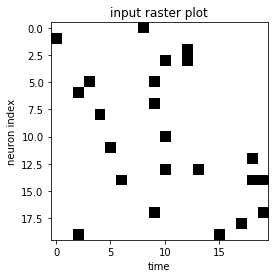

In [3]:
NUM_TIME_STEP = 20
FIRE_RATE = 0.05
np.random.seed(0)
inputs = np.random.rand(NUM_INPUTS,NUM_TIME_STEP)
inputs = (inputs > 1-FIRE_RATE).astype(float)

# We can visualize it using a raster plot
plt.imshow(inputs,cmap='gray_r')
plt.xlabel("time")
plt.ylabel("neuron index")
plt.title("input raster plot")

WLOG, we set the firing threshold to be unity. It will be reset to zero after firing. Everytime a neuron i receives a spike from `j`, neuron `i`'s membrane potential will be increased by `delta_v = COND*weights[i,j]`. Here `COND` is a constant that roughly corresponds to membrane conductance. For stability reason, one might want to scale `COND` accordingly.

In [4]:
COND = 10/NUM_INPUTS

With all those ingredients, we are now ready to simulate the "network"

In [5]:
def run_lab(inputs, weights):
    weights = np.copy(weights)
    input_dim, num_time_step = inputs.shape
    num_neurons, _ = weights.shape
    v_array = np.zeros(num_neurons)
    spike_recorder = np.zeros((num_neurons,num_time_step),dtype=np.int8)
    for t in range(num_time_step):
        v_array += COND*weights.dot(inputs[:,t])
        for (i, v) in enumerate(v_array):
            if v > 1.0: # a spike-event
                v_array[i] = 0.0
                spike_recorder[i, t] = 1
    return spike_recorder

Text(0.5, 1.0, 'output raster plot')

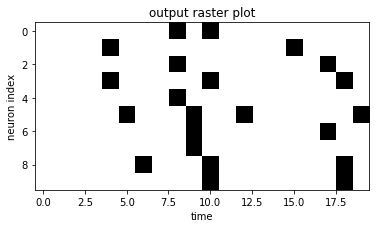

In [6]:
spike_recorder = run_lab(inputs, weights)
plt.imshow(spike_recorder,cmap='gray_r')
plt.xlabel("time")
plt.ylabel("neuron index")
plt.title("output raster plot")

Noise is inevitable in biological systems, what happens if we perturb the input
randomly by e.g. miss/add a few spikes, shift a spike forward/backward...etc?

In [24]:
def random_shift(A, p):
    A_ = np.copy(A)
    L = A_.shape[1]
    I, J = np.where(A_>0)
    random_nums = np.random.rand(len(I))
    for i in np.where(random_nums>1-p):
        A_[I[i],J[i]], A_[I[i],(J[i]+2)%L] = A_[I[i],(J[i]+2)%L], A_[I[i],J[i]]
    return A_

def random_add_miss(A, p):
    random_add = A*(np.random.random_sample(A.shape)>1-p)
    random_add = np.random.permutation(random_add)
    A_ = A*(np.random.random_sample(A.shape)>p)
    A_ += random_add
    A_ = (A_ > 0).astype(np.int8)
    return A_

def show_perturb_response(inputs, weights, perturb, title, p=0.2):
    fig, axes = plt.subplots(5, 2, sharex=True)#, sharey=True)
    for i, row in enumerate(axes):
        inputs_perturb = perturb(inputs, p)
        spike_recorder_perturb = run_lab(inputs_perturb, weights)
        row[0].imshow(inputs_perturb,cmap='gray_r')
        row[1].imshow(spike_recorder_perturb,cmap='gray_r')

    axes[0,0].set_title("Perturbed input")
    axes[0,1].set_title("Output")
    axes[-1,1].set_ylabel("neuron index")
    axes[-1,1].set_xlabel("time")
    plt.suptitle(title)


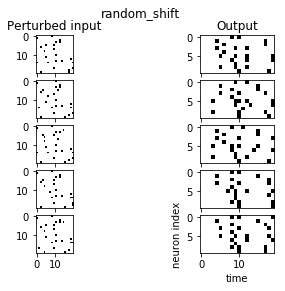

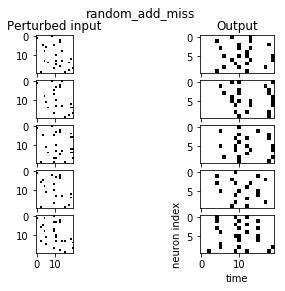

In [25]:
show_perturb_response(inputs, weights, random_shift, "random_shift", p=0.2)
show_perturb_response(inputs, weights, random_add_miss, "random_add_miss", p=0.2)

Due to the discontiuous nature of the dynamics, a perturbed input can give rise very distinct output. Similar phenomenon are also observed in cellular automaton. Clearly, this is undisirable in any biological system that has a purpose to *classify* inputs. Then question now is then how may SDTP help? To recap, SDTP is the phenomenon that when a pre- and post-synaptic neuron spike in within a time window, the synaptic weight changes. Ineteresting, the changes of the weight depends on precisely the relative timing between these tow spiking event. Below we see a "classical" STDP profile first observed by Bi and Poo experimentally. By convention a postive time lag means pre-synaptic spike *preceeds* the post-synaptic ones and vice versa.

Text(0, 0.5, 'percentage change in weight')

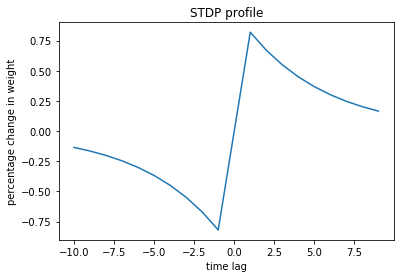

In [9]:
# STDP
def stdp_profile(t):
    # just a very crude one to illustrate the point
    w = 5 # stdp window
    frac = (t>0)*1.0*np.exp(-np.clip(t/w,0.,10)) - (t<0)*1.0*np.exp(np.clip(t/w,-10,0))
    return frac
ts = np.arange(-10,10)
plt.plot(ts,stdp_profile(ts))
plt.title("STDP profile")
plt.xlabel("time lag")
plt.ylabel("percentage change in weight")

Unlike ohter rate-based Hebbian learning rule, it is harder to understand the asymptotic effect of STDP. However, at an 
hand-waving level, an asymmetric STDP profile enhances the causal relation between pre- and post-synaptic neuron in the following manner; When a pre-synaptic spike is slightly ahead of the post- one, it means the particular pre-synaptic neuron has contributed to make it fire. Implied by the STDP profile, the synaptic weight of this pair of synapses will be strengthen. This means in the furture the the pre-synaptic will contiue to contribute more and more in making that post-synaptic neuron spike. A similar argument follows when pre-synaptic spike is slightly lag before of the post- one. In that case, this particular pre-synaptic spike has nothing to do with the post- spike. Implied by the STDP profile, thier connection will be weaken. The intuition that the author has in mind is that this enhancement of casuality deepens the basin of attraction of that particular input pattern, as in e.g. Hopfield network. Noetheless, the precise mathematical formualtion is still lacking at the moment. It is not obvious to the author how to extend the idea of energy/Lyapunov function to a temporal varying input. Now, we implement the simplest kind of STDP (i.e. without any triplet effect)

In [10]:
# some helper function
def diff(x, y):
    if len(x) == 0 or len(y) == 0:
        return np.array([])
    else:
        xx, yy = np.meshgrid(x, y)
        return np.transpose(xx-yy)
    
def run_lab_stdp(inputs, weights):
    weights = np.copy(weights)
    input_dim, num_time_step = inputs.shape
    num_neurons, _ = weights.shape
    #weights_trace = np.stack(weights for i in range(num_time_step))
    weights_trace = np.empty((num_time_step, num_neurons, input_dim))
    v_array = np.zeros(num_neurons)
    last_pre_spike = np.full(input_dim, -99, dtype=np.int)
    last_pos_spike = np.full(num_neurons, -99, dtype=np.int)
    spike_recorder = np.zeros((num_neurons,num_time_step), dtype=np.int8)
    for t in range(num_time_step):
        weights_trace[t,:,:] = weights
        v_array += COND*weights.dot(inputs[:,t])
        # update last spiking event
        pre_spike = inputs[:,t]>0
        pos_spike = v_array>1.0
        last_pre_spike += pre_spike*(t-last_pre_spike)
        last_pos_spike += pos_spike*(t-last_pos_spike)
        # reset spiked pos neuron
        v_array[pos_spike] = 0.0
        # execute STDP
        if sum(pre_spike):
            lag = diff(last_pos_spike, last_pre_spike[pre_spike])
            frac_change = stdp_profile(lag)
            weights[:, pre_spike] += weights[:, pre_spike]*frac_change
            weights[:, pre_spike] = np.clip(weights[:, pre_spike], 0., 1.)
        if sum(pos_spike):
            lag = diff(last_pos_spike[pos_spike], last_pre_spike)
            frac_change = stdp_profile(lag)
            weights[pos_spike, :] += weights[pos_spike, :]*frac_change
            weights[pos_spike, :] = np.clip(weights[pos_spike, :], 0., 1.)
    return spike_recorder, weights_trace, weights


Text(0, 0.5, 'synaptic weights')

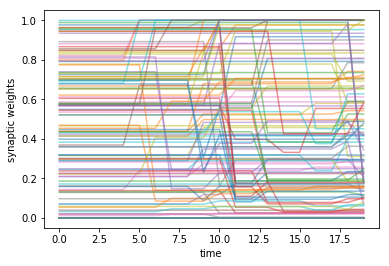

In [11]:
spike_recorder, weights_trace, trained_weights = run_lab_stdp(inputs, weights)
for i in range(NUM_NEURONS):
    for j in range(NUM_INPUTS):
        plt.plot(weights_trace[:,i,j], alpha=.5)
plt.xlabel("time")
plt.ylabel("synaptic weights")

From the above time trace of synaptic weights, we saw that most of the synaptic weights remain constant. Only the weights that participate in this particular input-output relation changes. This is a crucial observation; STDP would only strenghten the causal realtion between neuron that participate in this input-output relation. As a result, the output should be less sensitive to pertubation in input. In other words, STDP may stabilize input-output relation. We shall see it is indeed the case soon. For now, we shall see a few instance after training.

In [13]:
def variability(inputs, weights, perturb, p=0.2, num_sample=1000):
    _, num_time_step = inputs.shape
    num_neurons, _ = weights.shape
    num_dims = np.prod(num_neurons*num_time_step)
    outputs = np.empty((num_dims,num_sample))
    for i in range(num_sample):
        inputs_perturb = perturb(inputs, p)
        outputs[:,i] = run_lab(inputs_perturb, weights).flatten()
    fire_rate = np.sum(outputs.flatten())/num_sample
    return np.cov(outputs), fire_rate

In [14]:
print("random_shift:")
sigma, mu = variability(inputs, weights, random_shift, p=0.2, num_sample=10000)
print("Before training: variability = {:.3f}, average fire rate {:.3f}".format(np.linalg.norm(sigma),mu))
sigma, mu = variability(inputs, trained_weights, random_shift, p=0.2, num_sample=10000)
print("After training: variability = {:.3f}, average fire rate {:.3f}".format(np.linalg.norm(sigma),mu))

random_shift:
Before training: variability = 3.055, average fire rate 22.921
After training: variability = 2.658, average fire rate 20.680


In [15]:
print("random_add_miss:")
sigma, mu = variability(inputs, weights, random_add_miss, p=0.2, num_sample=10000)
print("Before training: variability = {:.3f}, average fire rate {:.3f}".format(np.linalg.norm(sigma),mu))
sigma, mu = variability(inputs, trained_weights, random_add_miss, p=0.2, num_sample=10000)
print("After training: variability = {:.3f}, average fire rate {:.3f}".format(np.linalg.norm(sigma),mu))

random_add_miss:
Before training: variability = 2.130, average fire rate 23.045
After training: variability = 1.919, average fire rate 19.039


Given an input pattern, ideally a classifier network should give identical output even the input is slightly perturbed. In reality some networks would be a completley distinct output and is therefore useful as a classifier. Form the above experiment, we saw for both kind of pertubations, after exposing the network the input, STDP does reduce the variability of the output when input is noisy. Yet, average fire rate has also decreased and might have given us the illusion. For example we consider an extreme case that the average fire rate after training is essentailly zero, then of course it has no variability at all! Thus we need a measure of how informative the output firing pattern actually is. An appropriate metric for this purpose could be the entropy of the output and inofrmation per spike. Furhtermore, we would like to see how these quantities change as the same input pattern is presented repeatedly for `num_sniffs` many times. Here training is done with the same input pattern but with different realization of noise(pertubation).


In [38]:
def train(inputs, weights, num_epochs=10): # Here an "epoch" means a complete presentation of an input
    input_dim, num_time_step = inputs.shape
    num_neurons, _ = weights.shape
    weights_trace_all = np.empty(
        (num_epochs*num_time_step, NUM_NEURONS, NUM_INPUTS))
    trained_weights = weights
    for i in range(num_epochs):
        _, weights_trace, trained_weights = run_lab_stdp(inputs, trained_weights)
        weights_trace_all[i*num_time_step:(i+1)*num_time_step,:,:] = weights_trace
    return trained_weights, weights_trace_all

def mybincount_array(xs):
    """
    arguments: xs is a list of arrays
    """
    counts = np.zeros(len(xs), dtype=np.int64)
    for i, x in enumerate(xs):
        isnew = True
        for j in range(i):
            if np.prod(np.equal(x,xs[j])):
                isnew = False
                counts[j] += 1
                break
        if isnew:
            counts[i] = 1
    return counts

# def f1_score(inputs, weights, perturb, p=0.2, num_sample=1000):
#     """There are probably better metric for this purpose"""
#     outputs = run_lab(inputs, weights) # "ground truth"
#     precisons, recalls = np.empty(num_sample), np.empty(num_sample)
#     f1s = np.empty(num_sample)
#     for i in range(num_sample):
#         inputs_perturb = perturb(inputs, p)
#         outputs_ = run_lab(inputs_perturb, weights)
#         true_pos = np.sum((outputs*outputs_).flatten())
#         retreived = np.sum(outputs_.flatten())
#         relevant = np.sum(outputs.flatten())
#         precisons[i] = true_pos/(retreived+1e-5)
#         recalls[i] = true_pos/(relevant+1e-5)
#         if precisons[i] != 0  or recalls[i] != 0 :
#             f1s[i] = 2*precisons[i]*recalls[i]/(precisons[i]+recalls[i])
#         else:
#             f1s[i] = 0
#     f1 = np.mean(f1s)
#     df1 = np.sqrt(np.var(f1s)/num_sample)
#     return f1, df1

    

# def show_f1(inputs, weights, perturb, title, p=0.2, num_sniffs=10):
#     trained_weights = np.copy(weights)
#     fs, dfs  = np.empty(num_sniffs), np.empty(num_sniffs)
#     fs[0], dfs[0] = f1_score(inputs, trained_weights, perturb)
#     for i in range(1,num_sniffs):
#         inputs_perturb = perturb(inputs, p)
#         _, trained_weights = train(inputs_perturb, trained_weights, num_epochs=1)
#         fs[i], dfs[i] = f1_score(inputs, trained_weights, perturb)#, p=0.2, num_sample=1000)
#     plt.figure()
#     plt.errorbar(np.arange(num_sniffs), fs, yerr=dfs)
#     plt.title(title)
#     plt.ylabel("F1")
#     plt.xlabel("number of sniffs")
#     return fs, dfs


def entropy_(x):
    return - sum(xx*np.log2(xx) for xx in x if xx>0 )


def entropy(inputs, weights, perturb, p=0.2, num_sample=1000):
    """A naive estimator of shannon entropy. Entropy estimation is
    a trick subject and in fact there is no known unbiased estimator
    for Shannon entropy. However, given large enough number samples,
    those effect should be negligible.
    """
    #outputs = np.empty(num_sample, dtype=np.int64)
    outputs = []
    num_spikes = 0.
    for i in range(num_sample):
        inputs_perturb = perturb(inputs, p)
        output = np.reshape(run_lab(inputs_perturb, weights), (-1,))
        outputs.append(output)
        num_spikes += sum(output)
    num_spikes = num_spikes/num_sample
    histo = mybincount_array(outputs)/num_sample
    return (entropy_(histo), num_spikes)

def show_entropy(inputs, weights, perturb, title, p=0.2, num_sniffs=10):
    trained_weights = np.copy(weights)
    fs, num_spikes = np.empty(num_sniffs), np.empty(num_sniffs)
    fs[0], num_spikes[0] = entropy(inputs, trained_weights, perturb)#, p=0.2, num_sample=1000)
    for i in range(1,num_sniffs):
        inputs_perturb = perturb(inputs, p)
        trained_weights, _ = train(inputs_perturb, trained_weights, num_epochs=1)
        fs[i], num_spikes[i] = entropy(inputs, trained_weights, perturb)#, p=0.2, num_sample=1000)
        #debug
        #print(h)
    fig, axes = plt.subplots(2, 1, sharex=True)
    #plt.errorbar(np.arange(num_sniffs), fs, yerr=dfs)
    axes[0].plot(np.arange(num_sniffs), fs)
    axes[0].set_ylabel("Output Entropy")
    #axes[0].set_xlabel("number of sniffs")
    axes[1].plot(np.arange(num_sniffs), fs/num_spikes)
    axes[1].set_ylabel("Information per output spike")
    axes[1].set_xlabel("number of sniffs")
    fig.suptitle(title)
    return trained_weights



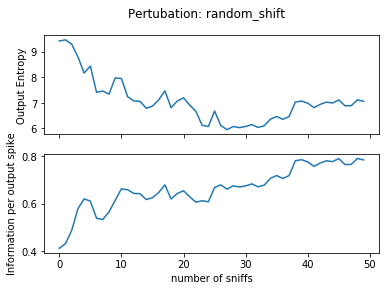

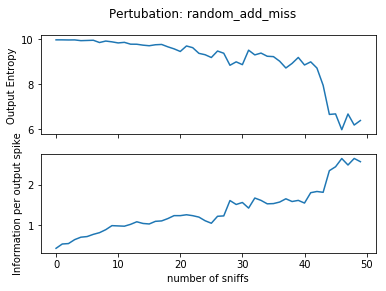

In [39]:
trained_weights_1 = show_entropy(
    inputs, weights, random_shift, "Pertubation: random_shift", p=0.2, num_sniffs=50)
trained_weights_2 = show_entropy(
    inputs, weights, random_add_miss, "Pertubation: random_add_miss", p=0.2, num_sniffs=50)

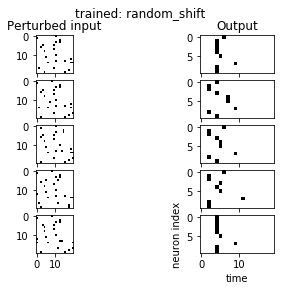

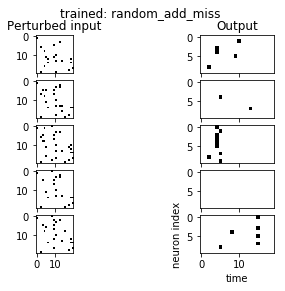

In [26]:
show_perturb_response(inputs, trained_weights_1, random_shift, "trained: random_shift", p=0.2)
show_perturb_response(inputs, trained_weights_2, random_add_miss, "trained: random_add_miss", p=0.2)

As we see, training with STDP significantly decrease the entropy of the output when input is perturbed by `random_shift` and `random_add_miss`. Further We conclude that at least with respect to these kinds of pertubation, STDP stabilizes the response to that particular input pattern, which is of edvident biological benefit: it helps to cluster similiar input to definite outut. In this regard, STDP indeed leads to an error correcting code in this precise manner.

## Conclusion

For sure, through only studying such a simple model, we would leave out tones of important biological details that could be crucial to learning in an animal. Nonetheless, toy model is not just a nice playground for theoretists but also helps us the pinpoint the most critical element of the phenomenon. 

There are many issues that have not been addressed in the notebook. For example, what happens when we have multiple classes? What is the effect of network size and other hyperparameteres such as stdp profile? How do we formulate ideas formally with proofs? What about more accuarte but more complicated neuron, synapse and STDP model? We would like to continue to explore those issues.